One combined spatial enhancement methods (e.g. arithmetic operations, gray level transformations, and/or sharpening spatial filters) to convert the image_1 to image_2.

1) Try to guess the processing steps she adopted. (Note the dynamic range and brightness of the enhanced image, and the noise introduced.)

2) Propose a pipeline of processes with the aim of approximating image_1 starting from image_2.

## Approximating image_2 starting from image_1.

In [1]:
import cv2 as cv
import numpy as np
import scipy.ndimage as ndi
from matplotlib import pyplot as plt

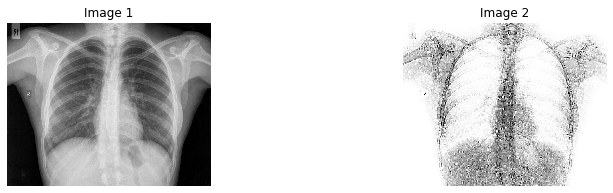

In [2]:
img_1 = cv.imread('image_1.jpg') # loads in grayscale
img_2 = cv.imread('image_2.jpg') # loads in grayscale 
# the images are importes as a numpy array

fig, axes = plt.subplots(1, 3, figsize=(13,3))
plt.subplot(121), plt.imshow(img_1, cmap='gray'), plt.axis('off'), plt.title('Image 1')
plt.subplot(122), plt.imshow(img_2, cmap='gray'), plt.axis('off'), plt.title('Image 2')
plt.show()

### Histogram equalization

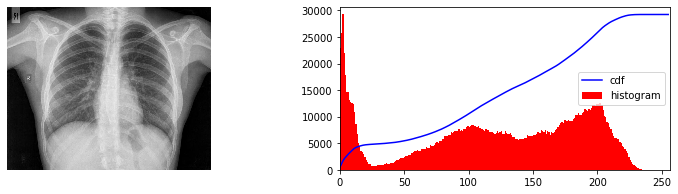

In [6]:
hist, bins = np.histogram(img_1.flatten(),256,[0,256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()

fig, axes = plt.subplots(1, 2, figsize=(13,3))

plt.subplot(121), plt.imshow(img_1, cmap='gray'), plt.axis('off')

plt.subplot(122)
plt.plot(cdf_normalized, color = 'b')
plt.hist(img_1.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'center right')
plt.show()

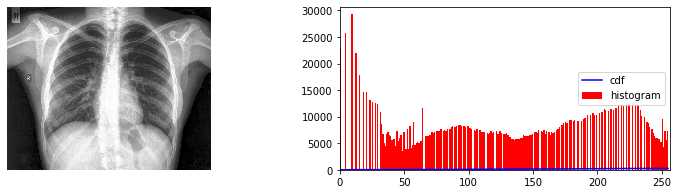

In [7]:
cdf_m = np.ma.masked_equal(cdf,0)
cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
cdf2 = np.ma.filled(cdf_m,0).astype('uint8')
img_1_fulspectr = cdf2[img_1]

fig, axes = plt.subplots(1, 2, figsize=(13,3))

plt.subplot(121), plt.imshow(img_1_fulspectr, cmap='gray'), plt.axis('off')

plt.subplot(122)
plt.plot(cdf2, color = 'b')
plt.hist(img_1_fulspectr.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'center right')
plt.show()

The pixels' values are streched to values of the full spectrum and this has improved the contrast of the image. This method leads to better view of the bone structure and the details in the x-ray image. 

## Gamma Correction
Prior to applying the power transformation: 
$$
O = I^{(1 / g)}
$$
the pixels' values are transformed to floats of the range [0,1] and then transformed back to integers of the range [0,255], in order to not have values clipped. I am choosing gamma value < 1 (1/g > 0) because I want to make my image darker, in order to see the lungs white (not in tones of gray) after the following transformations.  

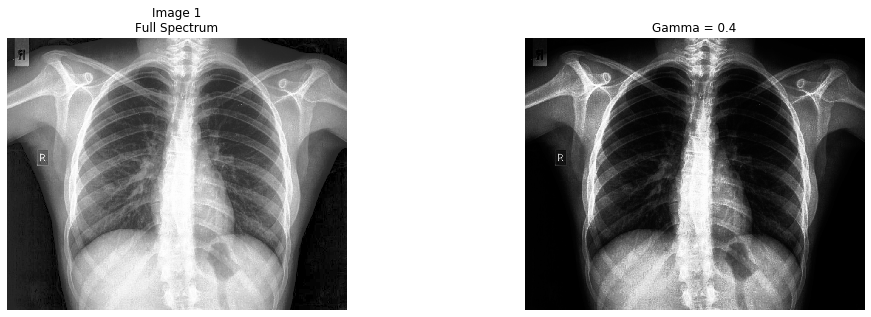

In [8]:
def adjust_gamma(image, gamma):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255    
        for i in np.arange(0, 256)]).astype("uint8")

    # apply gamma correction using the lookup table
    return cv.LUT(image, table)

fig, axes = plt.subplots(1, 3, figsize=(17,5))
plt.subplot(121), plt.imshow(img_1_fulspectr), plt.axis('off'), plt.title('Image 1' + '\n' + 'Full Spectrum')

adjusted = adjust_gamma(img_1_fulspectr, gamma=0.4)
plt.subplot(122), plt.imshow(adjusted), plt.axis('off'), plt.title('Gamma = 0.4')

plt.show()

## Complemet

The photographic negative is obtained by subtracting the pixel values of the image from 255. 

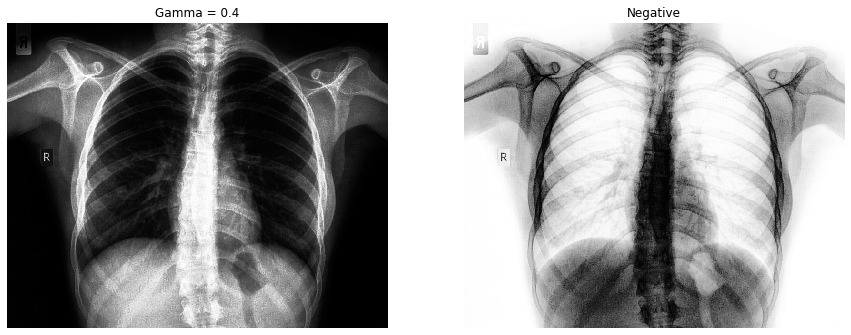

In [9]:
negative = (255-adjusted)

fig, axes = plt.subplots(1, 3, figsize=(15,7))

plt.subplot(121), plt.imshow(adjusted, cmap='gray'), plt.axis('off'), plt.title('Gamma = 0.4')
plt.subplot(122), plt.imshow(negative, cmap='gray'), plt.axis('off'), plt.title('Negative')

plt.show()

## Unsharp Masking

In order to create the noise observed in Image 2, an unsharp filter, that subtracts a scaled “unsharp” version of the image from the original image, is used.

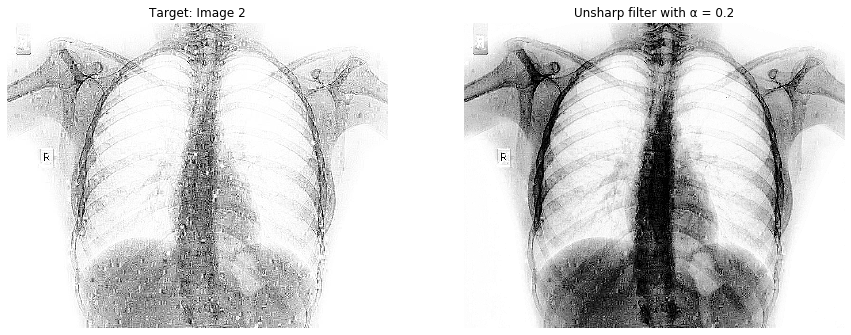

In [10]:
def unsharp(alpha=0.2):
    A1 = np.array([[-1,1,-1],[1,1,1],[-1,1,-1]])
    A2 = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
    return (alpha*A1+A2)/(alpha+1)

fig, axes = plt.subplots(1, 2, figsize=(15,7))
plt.subplot(121), plt.imshow(img_2, cmap='gray'), plt.title('Target: Image 2'), 
plt.axis('off')

kernel = unsharp(0.2)
dst1 = cv.filter2D(negative, -1, kernel, borderType=cv.BORDER_CONSTANT)
plt.subplot(122), plt.imshow(dst1, cmap='gray'), plt.title('Unsharp filter with α = 0.2'), 
plt.axis('off')

plt.show()

## Gamma Correction
A gamma value > 1 (1/g < 0) is chosen because I want to make my image brighter.

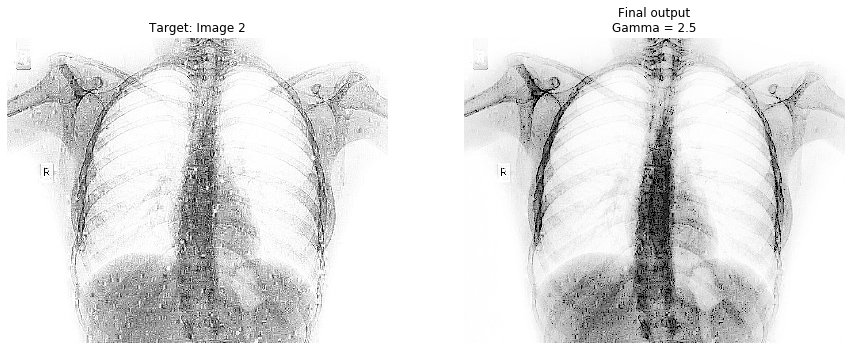

True

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(15,7))
plt.subplot(121), plt.imshow(img_2), plt.axis('off'), plt.title('Target: Image 2')

adjusted = adjust_gamma(dst1, gamma=2.5)
plt.subplot(122), plt.imshow(adjusted), plt.axis('off'), plt.title('Final output'+ '\n' + 'Gamma = 2.5')

plt.show()

cv.imwrite('Q1_final.jpg', adjusted) # The image is saved as a jpg

## Approximating image_1 starting from image_2.

## Median Filter

This filter takes median of all the pixel values under kernel area and replaces the central element with the median value. 
This filter is not affected by the oulier values, thus it reduces the salt-and-pepper noise effectively. 

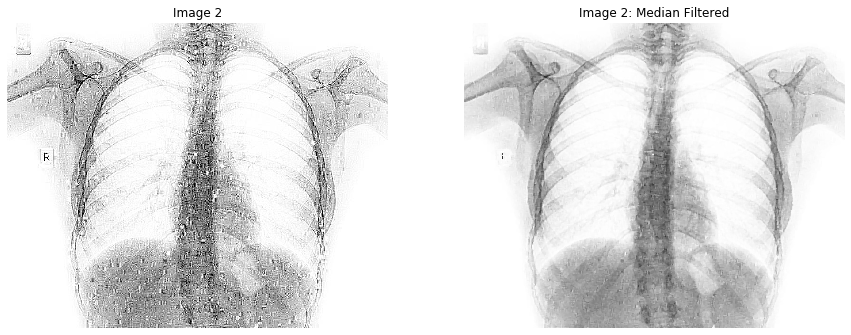

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(15,7))
plt.subplot(121), plt.imshow(img_2, cmap='gray'), plt.title('Image 2'), plt.axis('off')

median = cv.medianBlur(img_2,5)
plt.subplot(122), plt.imshow(median, cmap='gray'), plt.title('Image 2: Median Filtered'), plt.axis('off')
plt.show()

## Complement

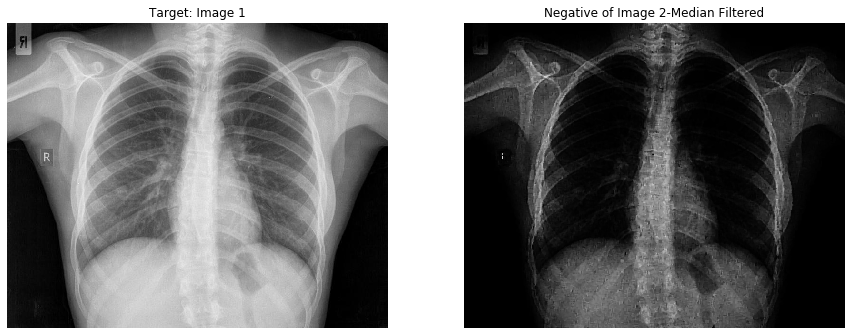

In [21]:
negative = (255-median)

fig, axes = plt.subplots(1, 3, figsize=(15,7))

plt.subplot(121), plt.imshow(img_1, cmap='gray'),plt.title('Target: Image 1'), plt.axis('off')
plt.subplot(122), plt.imshow(negative, cmap='gray'),plt.title('Negative of Image 2-Median Filtered'), plt.axis('off')

plt.show()

## Histogram Equalization

This step is performed in order to enhance contrast and have a better view of the bone structure and the details of the image. 

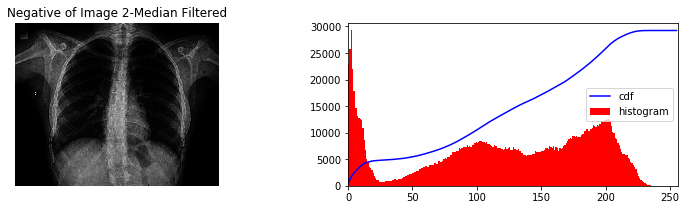

In [24]:
hist, bins = np.histogram(img_1.flatten(),256,[0,256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()

fig, axes = plt.subplots(1, 2, figsize=(13,3))

plt.subplot(121), plt.imshow(negative, cmap='gray'), plt.title('Negative of Image 2-Median Filtered'), plt.axis('off')

plt.subplot(122)
plt.plot(cdf_normalized, color = 'b')
plt.hist(img_1.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'center right')
plt.show()

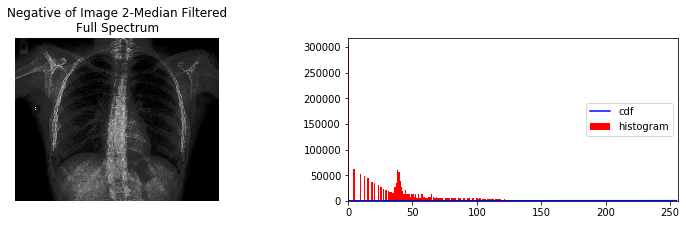

In [25]:
cdf_m = np.ma.masked_equal(cdf,0)
cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
cdf2 = np.ma.filled(cdf_m,0).astype('uint8')
negative_fulspectr = cdf2[negative]

fig, axes = plt.subplots(1, 2, figsize=(13,3))

plt.subplot(121), plt.imshow(negative_fulspectr, cmap='gray'), plt.title('Negative of Image 2-Median Filtered'+'\n'+'Full Spectrum'), plt.axis('off')

plt.subplot(122)
plt.plot(cdf2, color = 'b')
plt.hist(negative_fulspectr.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'center right')
plt.show()

#cv.imwrite('Test_gray.jpg', adjusted) 

## Gaussian filter

The Gaussian filter is a low pass filter based on the Gaussian probability distribution function. It is applied in order to get a smoother image. 

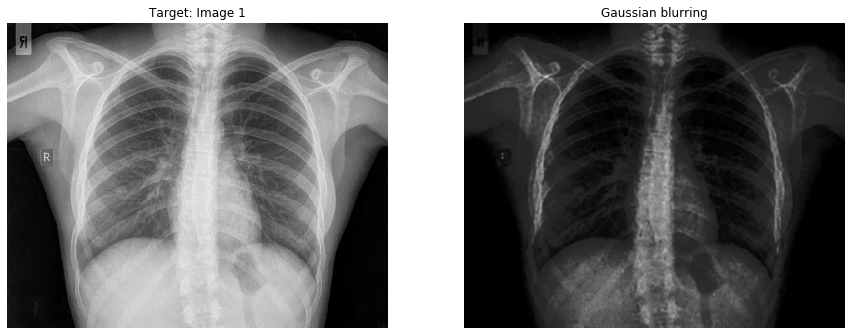

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(15,7))
plt.subplot(121), plt.imshow(img_1, cmap='gray'), plt.title('Target: Image 1'), plt.axis('off')
blur = cv.GaussianBlur(negative_fulspectr,(7,7),0)
plt.subplot(122), plt.imshow(blur, cmap='gray'), plt.title('Gaussian blurring'), plt.axis('off')
plt.show()

## Gamma Correction

A gamma value > 1 (1/g < 0) is chosen because I want to make my image brighter.

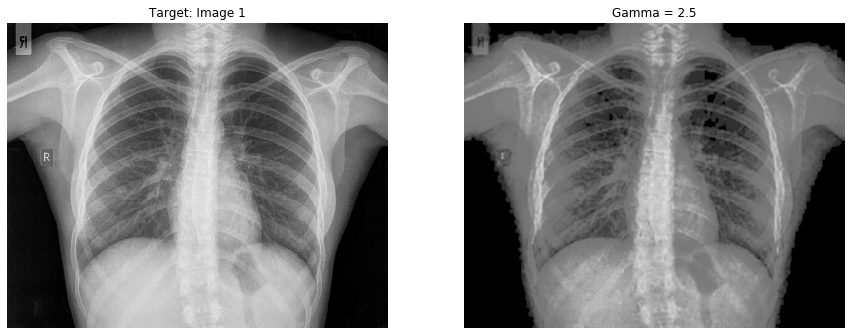

True

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(15,7))
plt.subplot(121), plt.imshow(img_1), plt.axis('off'), plt.title('Target: Image 1')

adjusted = adjust_gamma(blur, gamma=2.5)
plt.subplot(122), plt.imshow(adjusted), plt.axis('off'), plt.title('Gamma = 2.5')

plt.show()

cv.imwrite('Test_img2.jpg', adjusted) 

## Multiplying each pixel by a constant and adding a constant to each pixel 

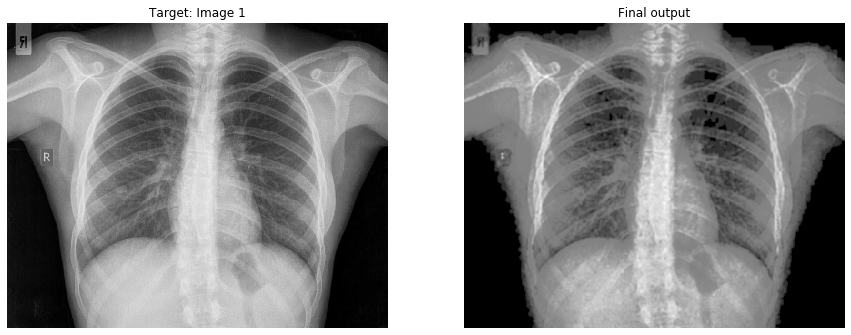

In [34]:
img = cv.imread('Test_img2.jpg',0) # loads in grayscale

alpha = 2
res = cv.multiply(img/255.0, alpha)

beta = 200
res = cv.add(res, beta)

fig, axes = plt.subplots(1, 2, figsize=(15,7))
plt.subplot(121), plt.imshow(img_1, cmap='gray'),plt.title('Target: Image 1'), plt.axis('off')
plt.subplot(122), plt.imshow(res*255, cmap='gray'),plt.title('Final output'), plt.axis('off')
plt.show()